# Developing the workflow for using the the AOP modeling for a target

Needed to create and index PUBCHEM AID_PUBCHEM OUTCOME_PUBCHEM CID

First get assays associated with a target

In [1]:
import config
import pandas as pd

TARGET = 'ESR1'

# get assays that belong to a particular
# target
query = 'SELECT tG.PUBCHEM_AID, tG.GeneSymbol ' \
        'FROM targets tG ' \
        'WHERE GeneSymbol == "{}"' \
        ''.format(TARGET)

genes_aids = pd.read_sql_query(query, con=config.Config.DB_URI)

print(genes_aids)

    PUBCHEM_AID GeneSymbol
0           713       ESR1
1           737       ESR1
2          1078       ESR1
3          1079       ESR1
4          1223       ESR1
5        588513       ESR1
6        588514       ESR1
7        743069       ESR1
8        743075       ESR1
9        743079       ESR1
10       743080       ESR1
11      1259244       ESR1
12      1259383       ESR1


Then just get compounds that are identified as "active" for modeling


In [2]:
aid_list = [str(aid)for aid in genes_aids.PUBCHEM_AID]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)

print(active_cmps.shape)

(3918, 3)


Now get the corresponding dose responses

In [3]:
sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

dr_query = 'SELECT  SID, AID, concentration as conc, response as resp ' \
                'FROM dose_response ' \
                'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

dose_responses = pd.read_sql_query(dr_query, con=config.Config.DB_URI)

print(dose_responses)

               SID      AID       conc     resp
0           842142      713   1.562500   1.1600
1           842142      713   1.562500  83.1070
2           842142      713   3.125000   1.0400
3           842142      713   3.125000  66.9530
4           842142      713   6.250000   1.1300
...            ...      ...        ...      ...
1099153  251919990  1259383  42.458599   2.6663
1099154  251919990  1259383  42.458599   2.8856
1099155  251919990  1259383  92.407204 -10.7652
1099156  251919990  1259383  92.407204  -9.6321
1099157  251919990  1259383  92.407204  -9.5876

[1099158 rows x 4 columns]


Merge with the actives dataframe to get cods back

In [4]:
# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
dr_merged = pd.merge(dose_responses, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(dr_merged.head())

      SID  AID    conc    resp      CID
0  842142  713  1.5625   1.160  5770444
1  842142  713  1.5625  83.107  5770444
2  842142  713  3.1250   1.040  5770444
3  842142  713  3.1250  66.953  5770444
4  842142  713  6.2500   1.130  5770444


Look at dose responses when you group be

In [5]:
counts = (
          dr_merged
          .groupby('CID')
          ['AID'].nunique()
          .sort_values(ascending=False)
          )

In [6]:
# determine analysis direction
# by checking if max response is negative

directions = dr_merged.groupby(['CID', 'AID'])['resp'].agg([('direction_up',
                                                               lambda x: x[x.abs() == x.abs().max()].iloc[0]>0)]).reset_index()

dr_merged = dr_merged.merge(directions, how='left', on=['CID', 'AID'])
dr_merged.head()

,SID,AID,conc,resp,CID,direction_up
0,842142,713,1.5625,1.160,5770444,True
1,842142,713,1.5625,83.107,5770444,True
2,842142,713,3.1250,1.040,5770444,True
3,842142,713,3.1250,66.953,5770444,True
4,842142,713,6.2500,1.130,5770444,True


In [29]:
# now convert negative responses
dr_merged['resp_r'] = dr_merged['resp'].copy()
dr_merged.loc[dr_merged.direction_up != True, 'resp_r'] = dr_merged.loc[dr_merged.direction_up != True, 'resp'] * -1
#dr_merged.loc[dr_merged.resp_r <= 0, 'resp_r'] = 0
dr_merged.head()

,SID,AID,conc,resp,CID,direction_up,resp_r,log(conc)
0,842142,713,1.5625,1.160,5770444,True,1.160,0.19382
1,842142,713,1.5625,83.107,5770444,True,83.107,0.19382
2,842142,713,3.1250,1.040,5770444,True,1.040,0.49485
3,842142,713,3.1250,66.953,5770444,True,66.953,0.49485
4,842142,713,6.2500,1.130,5770444,True,1.130,0.79588


/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:xlabel='log(conc)', ylabel='resp_r'>

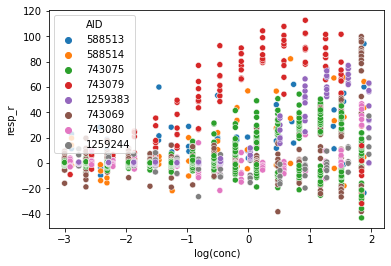

In [30]:
import seaborn as sns
import numpy as np
dr_merged['log(conc)'] = np.log10(dr_merged['conc'])

grouped_by_cid = dr_merged.groupby('CID')

cid = counts.index[0]

data = grouped_by_cid.get_group(cid)
data['AID'] = data['AID'].astype(str)
sns.scatterplot(data=data, x='log(conc)', y='resp_r', hue='AID')

<AxesSubplot:xlabel='log(conc)', ylabel='resp_r'>

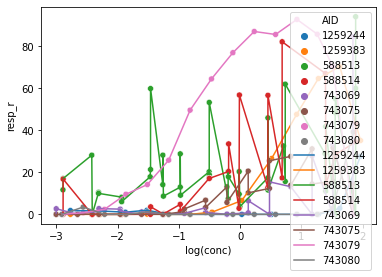

In [34]:
response_avg = data.groupby(['AID', 'log(conc)'])['resp_r'].mean().reset_index()

response_avg.loc[response_avg.resp_r <= 0, 'resp_r'] = 0

sns.scatterplot(data=response_avg, x='log(conc)', y='resp_r', hue='AID')
sns.lineplot(data=response_avg, x='log(conc)', y='resp_r', hue='AID')

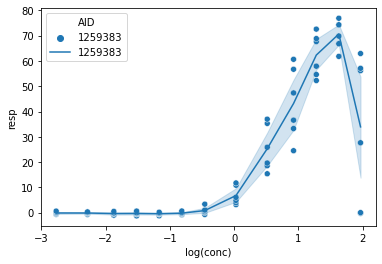

In [44]:
data_one = data[(data.AID == '1259383') & (data.SID == 144213946)]
sns.scatterplot(data=data_one, x='log(conc)', y='resp', hue='AID')
sns.lineplot(data=data_one, x='log(conc)', y='resp', hue='AID')

data_one_r = data_one.groupby('log(conc)')['resp'].mean().reset_index()

    log(conc)       resp
0   -2.769641  -0.118050
1   -2.282597  -0.124050
2   -1.872484  -0.338500
3   -1.518367  -0.303083
4   -1.166761  -0.396283
5   -0.815354  -0.197950
6   -0.457502   0.843317
7    0.028059   6.785000
8    0.514136  25.303267
9    0.923576  43.196517
10   1.277621  62.347833
11   1.627966  70.676583
12   1.965706  33.950633


<AxesSubplot:xlabel='log(conc)', ylabel='resp'>

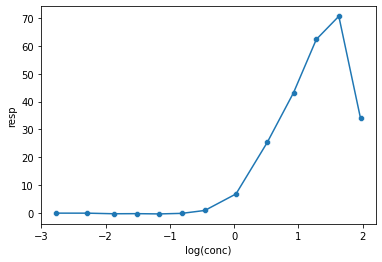

In [47]:
print(data_one_r)
sns.scatterplot(data=data_one_r, x='log(conc)', y='resp')
sns.lineplot(data=data_one_r, x='log(conc)', y='resp')


In [71]:
# curveP

def curveP(data,
           RNP=100, # max response
           THR=15, # baseline threshold
           MXDV=5, # maximum allowed deviation from monotonicity
            ):
    """ take from alex books chapter curveP https://link.springer.com/content/pdf/10.1007/978-1-0716-2213-1.pdf """

    data = data.sort_values('log(conc)')

    data.loc[data.resp < THR, 'resp'] = 0
    data.loc[data.resp > RNP, 'resp'] = RNP

    # correct blips
    if (abs(data.iloc[0].resp) > 0) and (data.iloc[1].resp == 0 and data.iloc[2].resp == 0):
        data.loc[data.index[0], 'resp'] = 0

    curve_direction = data.iloc[0].resp - data.iloc[-1].resp

    # if (curve_direction < THR) and ((data.resp.std() < MXDV) or max(data.iloc[0].resp, data.iloc[-1]) < THR):
    #     # go to step 9
    #     pass

    # find poiints that violate global directions
    gds = (abs(curve_direction) + MXDV < (data.resp - data.iloc[0].resp).abs())

    if gds.sum() < 2:
        # step 9
        pass

    # get directions
    # if increasing, -1
    # if decreasing, 1
    diffs = data.resp.diff().fillna(0)
    signs = diffs.copy()
    signs[diffs.abs() <= MXDV] = 0
    signs[(diffs.abs() > MXDV) & (diffs > 0)] = -1
    signs[(diffs.abs() > MXDV) & (diffs < 0)] = 1

    # data points not in the correct direction
    correct_direction = curve_direction*signs >= 0

    # assign incorrect data points
    # the previous value
    data_corrected = data.copy()
    data_corrected.loc[~correct_direction, 'resp'] = np.nan
    data_corrected['resp'] = data_corrected['resp'].fillna(method='ffill')
    return data_corrected


data_one_r_corrected = curveP(data_one_r)

    log(conc)       resp
0   -2.769641  -0.118050
1   -2.282597  -0.124050
2   -1.872484  -0.338500
3   -1.518367  -0.303083
4   -1.166761  -0.396283
5   -0.815354  -0.197950
6   -0.457502   0.843317
7    0.028059   6.785000
8    0.514136  25.303267
9    0.923576  43.196517
10   1.277621  62.347833
11   1.627966  70.676583
12   1.965706  33.950633
    log(conc)       resp
0   -2.769641   0.000000
1   -2.282597   0.000000
2   -1.872484   0.000000
3   -1.518367   0.000000
4   -1.166761   0.000000
5   -0.815354   0.000000
6   -0.457502   0.000000
7    0.028059   0.000000
8    0.514136  25.303267
9    0.923576  43.196517
10   1.277621  62.347833
11   1.627966  70.676583
12   1.965706  70.676583


<AxesSubplot:xlabel='log(conc)', ylabel='resp'>

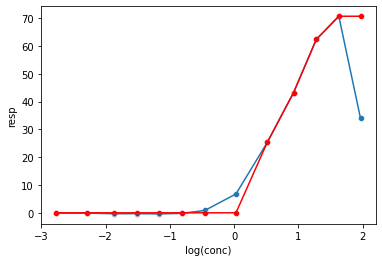

In [73]:
print(data_one_r)
sns.scatterplot(data=data_one_r, x='log(conc)', y='resp')
sns.lineplot(data=data_one_r, x='log(conc)', y='resp')

print(data_one_r_corrected)

sns.scatterplot(data=data_one_r_corrected, x='log(conc)', y='resp', color='red')
sns.lineplot(data=data_one_r_corrected, x='log(conc)', y='resp', color='red')
